<a href="https://colab.research.google.com/github/parsa-abbasi/Sentiment-Analysis/blob/master/Multiclass-Classification/DL_KerasEmb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements

## Install required libraries

In [1]:
!pip install hazm
!pip install stopwords_guilannlp
!pip install matplotlib==3.1.0

## Import Libraries

In [2]:
# General
import numpy as np
import pandas as pd
import codecs
from google.colab import files
# Keras
from keras import optimizers
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Embedding, Dropout
from keras.layers import GlobalMaxPool1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import CuDNNLSTM, LSTM, Bidirectional
from keras.layers.convolutional import Conv1D
from keras.utils.np_utils import to_categorical
from keras.metrics import categorical_accuracy
from keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# Preprocessing
from stopwords_guilannlp import stopwords_output
from hazm import *
# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
from keras.utils import plot_model
# Measuring metrics
from sklearn.metrics import f1_score

Using TensorFlow backend.


# Upload dataset files

Upload dataset files to colab environment

You can access to dataset files through following links:

(x_train, x_test, y_train, y_test)
- [Original dataset](https://github.com/parsa-abbasi/Sentiment-Analysis/tree/master/Dataset/Original)
- [Balanced with extra data](https://github.com/parsa-abbasi/Sentiment-Analysis/tree/master/Dataset/BalancedWithExtra)
- [Data Augmentation - Full Translate](https://github.com/parsa-abbasi/Sentiment-Analysis/tree/master/Dataset/FullTranslate)
- [Data Augmentation - Synonyms](https://github.com/parsa-abbasi/Sentiment-Analysis/tree/master/Dataset/Synonyms)

In [4]:
from google.colab import files
uploaded = files.upload()

Saving x_test.csv to x_test.csv
Saving x_train.csv to x_train.csv
Saving y_test.csv to y_test.csv
Saving y_train.csv to y_train.csv



# Import & Analyze Dataset

In [0]:
x_train = pd.read_csv('x_train.csv', sep='\t', index_col=None, header=None, encoding="utf-8")[1]
x_test = pd.read_csv('x_test.csv', sep='\t', index_col=None, header=None, encoding="utf-8")[1]
y_train = pd.read_csv('y_train.csv', sep='\t', index_col=None, header=None)[1]
y_test = pd.read_csv('y_test.csv', sep='\t', index_col=None, header=None)[1]

In [0]:
# The dataset csv files created using old version of Pandas
# so we need to do some additional preparation
x_train = x_train[1:]
x_train = x_train.reset_index(drop=True)
x_test = x_test[1:]
x_test = x_test.reset_index(drop=True)
y_train = y_train[1:]
y_train = y_train.reset_index(drop=True)
y_test = y_test[1:]
y_test = y_test.reset_index(drop=True)

In [7]:
print('Number of training sentence: ', x_train.shape)
print('Number of training label: ', y_train.shape)
print('Number of testing sentence: ', x_test.shape)
print('Number of testing label: ', y_test.shape)

Number of training sentence:  (5561,)
Number of training label:  (5561,)
Number of testing sentence:  (1854,)
Number of testing label:  (1854,)


In [0]:
# Convert dataframes to numpy arrays
x_train = np.asarray(x_train)
x_test = np.asarray(x_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [9]:
# See the data number of sentence in each category 
from collections import Counter
cnt = Counter(y_train)
cnt = dict(cnt)
print(cnt)

{'1': 1623, '2': 988, '0': 2409, '-1': 513, '-2': 28}


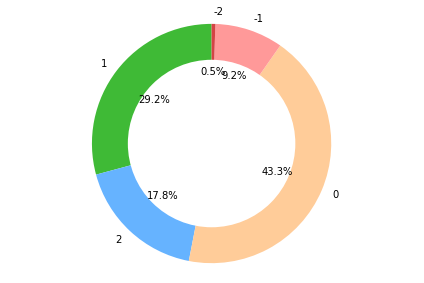

In [10]:
labels = list(cnt.keys())
sizes = list(cnt.values())
colors = ['#3fba36', '#66b3ff','#ffcc99','#ff9999', '#d44444']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
# Decomment following line if you want to save the figure
# plt.savefig('balanced_with_extra.png')
plt.show()

In [0]:
# Decomment following line if you want to download dataset figure
# files.download('balanced_with_extra.png')

# Preprocess

In [0]:
puncs = ['،', '.', ',', ':', ';', '"']
normalizer = Normalizer()
lemmatizer = Lemmatizer()

# turn a doc into clean tokens
def clean_doc(doc):
    doc = normalizer.normalize(doc) # Normalize document using Hazm Normalizer
    tokenized = word_tokenize(doc)  # Tokenize text
    tokens = []
    for t in tokenized:
      temp = t
      for p in puncs:
        temp = temp.replace(p, '')
      tokens.append(temp)
    # tokens = [w for w in tokens if not w in stop_set]    # Remove stop words
    tokens = [w for w in tokens if not len(w) <= 1]
    tokens = [w for w in tokens if not w.isdigit()]
    tokens = [lemmatizer.lemmatize(w) for w in tokens] # Lemmatize sentence words using Hazm Lemmatizer
    tokens = ' '.join(tokens)
    return tokens

# Prepare data for Deep Learning model

## Apply preprocessing to data

In [0]:
# Apply preprocessing step to training data
train_docs = np.empty_like(x_train)
for index, document in enumerate(x_train):
  train_docs[index] = clean_doc(document)

In [0]:
# Applying preprocessing step to test data
test_docs = np.empty_like(x_test)
for index, document in enumerate(x_test):
  test_docs[index] = clean_doc(document)

## Setting tokenizer up

In [0]:
num_words = 2000

# Create the tokenizer
tokenizer = Tokenizer(num_words=num_words)

# fFt the tokenizer on the training documents
tokenizer.fit_on_texts(train_docs)

In [0]:
# Find maximum length of training sentences
max_length = max([len(s.split()) for s in train_docs])

## Embed sentences

In [0]:
# Embed training sequences
encoded_docs = tokenizer.texts_to_sequences(train_docs)

# Pad embeded training sequences
x_train_padded = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [0]:
# Define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index)

In [0]:
# Embed testing sequences
encoded_docs = tokenizer.texts_to_sequences(test_docs)
# Pad testing sequences
x_test_padded = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

# Deep Learning Models

In [0]:
# Prepare labels for categorical prediction
categorical_y_train = to_categorical(y_train, 5)
categorical_y_test = to_categorical(y_test, 5)

## B-LSTM Model

In [0]:
model_blstm = Sequential()
model_blstm.add(Embedding(vocab_size, 300, input_length=max_length))
model_blstm.add(Bidirectional(CuDNNLSTM(300, return_sequences=True, name='lstm_layer')))
model_blstm.add(GlobalMaxPool1D())
model_blstm.add(Dropout(0.2))
model_blstm.add(Dense(300, activation="relu"))
model_blstm.add(Dropout(0.1))
model_blstm.add(Dense(5, activation='softmax'))

In [40]:
model_blstm.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[categorical_accuracy])

model_blstm.summary()
batch_size_blstm = 64
epochs_blstm = 7

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 297, 300)          2092500   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 297, 600)          1444800   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 600)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 300)               180300    
_________________________________________________________________
dropout_5 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                

In [41]:
# Train model
hist_blstm = model_blstm.fit(x_train_padded, categorical_y_train, batch_size=batch_size_blstm, epochs=epochs_blstm)

Epoch 1/7
5561/5561 [==============================] - 8s 1ms/step - loss: 1.2314 - categorical_accuracy: 0.4742
Epoch 2/7
5561/5561 [==============================] - 7s 1ms/step - loss: 0.8591 - categorical_accuracy: 0.6666
Epoch 3/7
5561/5561 [==============================] - 7s 1ms/step - loss: 0.6635 - categorical_accuracy: 0.7475
Epoch 4/7
5561/5561 [==============================] - 7s 1ms/step - loss: 0.5318 - categorical_accuracy: 0.7995
Epoch 5/7
5561/5561 [==============================] - 7s 1ms/step - loss: 0.4281 - categorical_accuracy: 0.8457
Epoch 6/7
5561/5561 [==============================] - 7s 1ms/step - loss: 0.3617 - categorical_accuracy: 0.8759
Epoch 7/7
5561/5561 [==============================] - 7s 1ms/step - loss: 0.2890 - categorical_accuracy: 0.8980


In [42]:
# Evaluate model
loss_blstm, acc_blstm = model_blstm.evaluate(x_test_padded, categorical_y_test, verbose=0)
print('Test Accuracy: %f' % (acc_blstm*100))

Test Accuracy: 64.347357


In [0]:
# Get prediction label
y_pred_blstm = model_blstm.predict_classes(x_test_padded[:-1])

## CNN Model

In [0]:
model_cnn = Sequential()
model_cnn.add(Embedding(vocab_size, 300, input_length=max_length))
model_cnn.add(Conv1D(filters=64, kernel_size=4, activation='relu', padding='same'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=64, kernel_size=8, activation='relu', padding='same'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=64, kernel_size=16, activation='relu', padding='same'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dropout(0.1))
model_cnn.add(Dense(500, activation="sigmoid"))
model_cnn.add(Dense(5, activation='softmax'))

In [45]:
model_cnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[categorical_accuracy])

model_cnn.summary()
batch_size_cnn = 64
epochs_cnn = 10

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 297, 300)          2092500   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 297, 64)           76864     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 148, 64)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 148, 64)           32832     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 74, 64)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 74, 64)            65600     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 64)               

In [46]:
# Train model
hist_cnn = model_cnn.fit(x_train_padded, categorical_y_train, batch_size=batch_size_cnn, epochs=epochs_cnn)

Epoch 1/10
5561/5561 [==============================] - 2s 301us/step - loss: 1.1961 - categorical_accuracy: 0.4844
Epoch 2/10
5561/5561 [==============================] - 1s 167us/step - loss: 0.9029 - categorical_accuracy: 0.6564
Epoch 3/10
5561/5561 [==============================] - 1s 172us/step - loss: 0.7700 - categorical_accuracy: 0.7283
Epoch 4/10
5561/5561 [==============================] - 1s 170us/step - loss: 0.6219 - categorical_accuracy: 0.7790
Epoch 5/10
5561/5561 [==============================] - 1s 175us/step - loss: 0.4821 - categorical_accuracy: 0.8392
Epoch 6/10
5561/5561 [==============================] - 1s 170us/step - loss: 0.3480 - categorical_accuracy: 0.8950
Epoch 7/10
5561/5561 [==============================] - 1s 173us/step - loss: 0.2514 - categorical_accuracy: 0.9318
Epoch 8/10
5561/5561 [==============================] - 1s 172us/step - loss: 0.1795 - categorical_accuracy: 0.9576
Epoch 9/10
5561/5561 [==============================] - 1s 169us/step - 

In [47]:
# Evaluate model
loss_cnn, acc_cnn = model_cnn.evaluate(x_test_padded, categorical_y_test, verbose=0)
print('Test Accuracy: %f' % (acc_cnn*100))

Test Accuracy: 63.430421


In [0]:
# Get prediction label
y_pred_cnn = model_cnn.predict_classes(x_test_padded[:-1])

# Confusion Matrix

In [0]:
y_test_label = []
for counter in range(0, len(categorical_y_test)-1):
  label = np.argmax(categorical_y_test[:-1][counter])
  y_test_label.append(label)
y_test_label = np.array(y_test_label)

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    print(im)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

class_names = np.array([0, 1, 2, -2, -1])
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[558 110  11   0  64]
 [140 333  48   1  38]
 [ 21 106 225   0   2]
 [  3   1   2   0   6]
 [ 73  32   2   1  76]]
AxesImage(54,36;334.8x217.44)
Normalized confusion matrix
[[0.75 0.15 0.01 0.   0.09]
 [0.25 0.59 0.09 0.   0.07]
 [0.06 0.3  0.64 0.   0.01]
 [0.25 0.08 0.17 0.   0.5 ]
 [0.4  0.17 0.01 0.01 0.41]]
AxesImage(54,36;334.8x217.44)


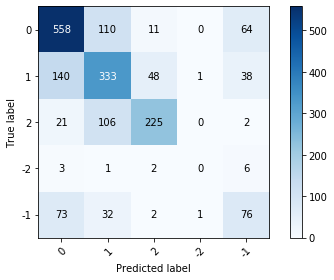

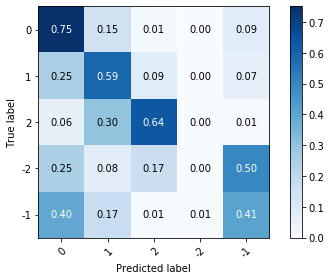

In [51]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_label, y_pred_blstm, classes=class_names)
plt.savefig('cm-blstm.png')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test_label, y_pred_blstm, classes=class_names, normalize=True)
# Decomment following line if you want to save the figure
plt.savefig('cm-blstm-normalized.png')
plt.show()

In [0]:
# Decomment following line if you want to download confusion matrix figure
# files.download('cm-blstm.png')
# files.download('cm-blstm-normalized.png')

Confusion matrix, without normalization
[[516 158   9   0  60]
 [128 334  68   0  30]
 [  7  88 256   0   3]
 [  2   5   1   0   4]
 [ 69  44   2   0  69]]
AxesImage(54,36;334.8x217.44)
Normalized confusion matrix
[[0.69 0.21 0.01 0.   0.08]
 [0.23 0.6  0.12 0.   0.05]
 [0.02 0.25 0.72 0.   0.01]
 [0.17 0.42 0.08 0.   0.33]
 [0.38 0.24 0.01 0.   0.38]]
AxesImage(54,36;334.8x217.44)


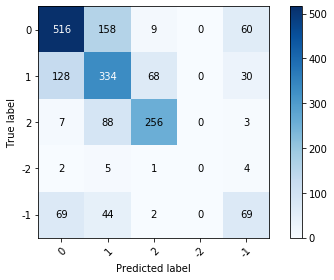

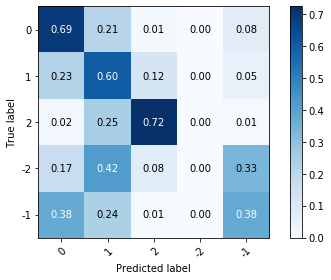

In [53]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_label, y_pred_cnn, classes=class_names)
plt.savefig('cm-cnn.png')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test_label, y_pred_cnn, classes=class_names, normalize=True)
plt.savefig('cm-cnn-normalized.png')
plt.show()

In [0]:
# Decomment following line if you want to download confusion matrix figure
# files.download('cm-cnn.png')
# files.download('cm-cnn-normalized.png')

## F1 Score

In [55]:
print("F1 score of KerasEmb B-LSTM model:")
f1_score(y_test_label, y_pred_blstm, average='weighted')

F1 score of KerasEmb B-LSTM model:


0.6418990335654436

In [56]:
print("F1 score of KerasEmb CNN model:")
f1_score(y_test_label, y_pred_cnn, average='weighted')

F1 score of KerasEmb CNN model:


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6331574445830831

# Model Visualization

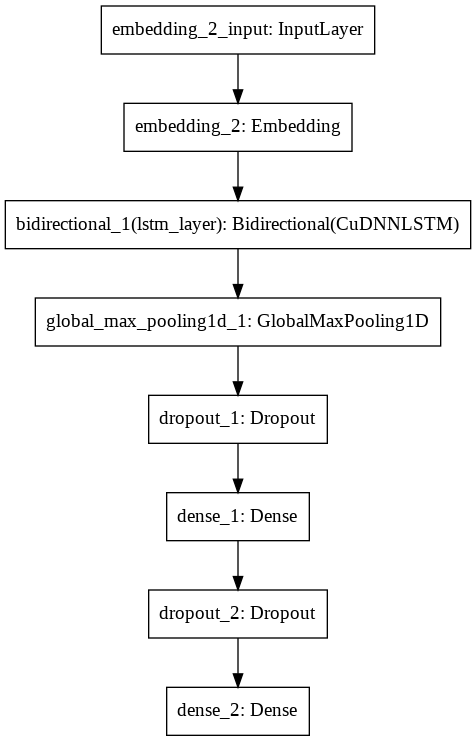

In [0]:
plot_model(model_blstm, to_file='multiclass-blstm.png')

In [0]:
# Decomment following line if you want to download model figure
# files.download('multiclass-blstm.png')

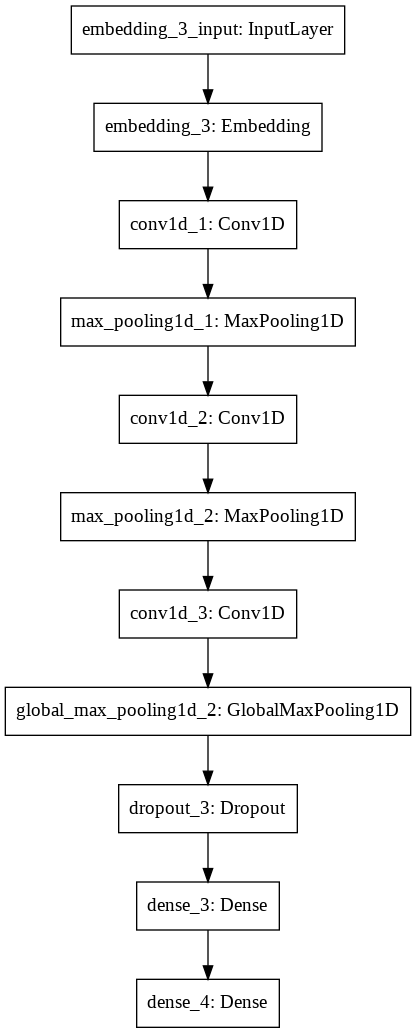

In [0]:
plot_model(model_cnn, to_file='multiclass-cnn.png')

In [0]:
# Decomment following line if you want to download model figure
# files.download('multiclass-cnn.png')